# Import relevant packages

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal
import re 

import brightway2 as bw

import joblib
from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.dummy import DummyRegressor

# Import data

## Brightway2 data

In [191]:
# import eidl
# bw.projects.set_current('LCIA_translator')

# eidl.get_ecoinvent()

logging in to ecoinvent homepage...
login successful!

 available versions:
a 3.9.1
b 3.9
c 3.8
d 3.7.1
e 3.7
f 3.6
g 3.5
h 3.4
i 3.3
j 3.2
k 3.10
l 3.1
m 3.01

 system models:
a apos
b consequential
c cutoff
database already downloaded
Extracting XML data from 21238 datasets
Extracted 21238 datasets in 48.77 seconds
No biosphere database present in your current project: LCIA_translator
You can run "bw2setup()" if this is a new project. Run it now?
Creating default biosphere

Applying strategy: normalize_units


Writing activities to SQLite3 database:


Applying strategy: drop_unspecified_subcategories
Applying strategy: ensure_categories_are_tuples
Applied 3 strategies in 0.01 seconds


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/23/2024 16:26:12
  Finished: 09/23/2024 16:26:13
  Total time elapsed: 00:00:00
  CPU %: 79.90
  Memory %: 11.18
Created database: biosphere3
Creating default LCIA methods

Wrote 762 LCIA methods with 227223 characterization factors
Creating core data migrations

Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
App

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:51


Title: Writing activities to SQLite3 database:
  Started: 09/23/2024 16:29:16
  Finished: 09/23/2024 16:30:07
  Total time elapsed: 00:00:51
  CPU %: 84.00
  Memory %: 11.75
Created database: cutoff391


In [192]:
# if ecoinvent database already downloaded
bw.projects.set_current('LCIA_translator')

In [194]:
print(bw.databases)
bsdb = bw.Database('biosphere3') # biosphere database for ecoinvent 3.9.1
eidb = bw.Database('cutoff391')
print("The imported ecoinvent database is of type {} and has a length of {}.".format(type(bsdb), len(bsdb)))
print("The imported ecoinvent database is of type {} and has a length of {}.".format(type(eidb), len(eidb)))

Databases dictionary with 2 object(s):
	biosphere3
	cutoff391
The imported ecoinvent database is of type <class 'bw2data.backends.peewee.database.SQLiteBackend'> and has a length of 4709.
The imported ecoinvent database is of type <class 'bw2data.backends.peewee.database.SQLiteBackend'> and has a length of 21238.


In [195]:
activity = [i for i in eidb ][0].as_dict()
classification = activity['classifications']

In [161]:
activity

{'comment': "Inventoried waste contains 21% paper; 8% Mixed cardbord; 15% plastics; 3% laminated materials; 2% laminated packaging, e.g. tetra bricks; 3% combined goods e.g.  dipers; 3% glass; 2% textiles; 8% minerals; 9% natural products; 22% compostable material; 2.65% inert metals; 1% volatile metals; 0.0065% batteries; 0.34% electronic goods; .\nwaste composition (wet, in ppm): upper heating value 13.27 MJ/kg; lower heating value 11.74 MJ/kg; H2O 228830; O 257060; H 48250; C 334230; S 1119; N 3123.8; P 893.79; B 7.1933; Cl 6866.2; Br 13.552; F 56.358; I 0.0121; Ag 0.714; As 0.62521; Ba 149.04; Cd 11.748; Co 1.3453; Cr 315.21; Cu 1212.8; Hg 1.4424; Mn 259.36; Mo 1.9551; Ni 107.38; Pb 502.43; Sb 22.564; Se 0.31969; Sn 73.44; V 9.2147; Zn 1311.2; Be n.a.; Sc n.a.; Sr n.a.; Ti n.a.; Tl n.a.; W n.a.; Si 48510; Fe 29996; Ca 14062; Al 12420; K 2059.7; Mg 3377.7; Na 5143.9; \nShare of carbon in waste that is biogenic 60.4%.\nOverall degradability of waste during 100 years: 18.73%.\n[This d

In [163]:
activity.get('classifications', None)[1][1]

'3821:Treatment and disposal of non-hazardous waste'

In [145]:
activity['filename'][:73]

'a9355f20-2065-5eaf-af0f-9505122f3540_d69294d7-8d64-4915-a896-9996a014c410'

In [127]:
classification[1][1][:2]

'34'

In [199]:
uid = []
classifications = []
for activity in eidb:
    uid.append(activity.as_dict().get('filename', None)[:73])
    classifications.append(activity.as_dict().get('classifications', None))

pd.concat([pd.DataFrame(uid), pd.DataFrame(classifications)], axis=1)

,0,0,1,2,3
0,7518017c-ac2f-501e-8ceb-e10c7f6189b3_aed42e37-...,"(ISIC rev.4 ecoinvent, 0220:Logging)","(CPC, 031: Wood in the rough)",None,None
1,6f5604f3-c377-5a9c-aaf9-5c7d3eb5501c_c5adb1fb-...,"(ISIC rev.4 ecoinvent, 3600:Water collection, ...","(EcoSpold01Categories, water supply/production)","(CPC, 18000: Natural water)",None
2,5f3f8029-1b6e-51c8-aba0-2e142f08ecc6_f9895e44-...,"(EcoSpold01Categories, transport systems/road)","(ISIC rev.4 ecoinvent, 4923:Freight transport ...","(CPC, 6511: Road transport services of freight)",None
3,359e3e5f-02c1-52b2-bfa7-b917dbd2b577_c2019cb4-...,"(EcoSpold01Categories, electronics/services)","(ISIC rev.4 ecoinvent, 8219:Photocopying, docu...","(CPC, 85: Support services)",None
4,8fa412cc-5af4-5283-aaa2-23188173b0e4_9891d347-...,"(ISIC rev.4 ecoinvent, 0123:Growing of citrus ...","(CPC, 01322: Lemons and limes)",None,None
...,...,...,...,...,...
21233,3f902e87-682e-52f1-a487-81fddbe11a1b_3fbcb3ea-...,"(ISIC rev.4 ecoinvent, 2012:Manufacture of fer...","(CPC, 34621: Superphosphate)",None,None
21234,f4404622-6af6-5724-bc9d-16f8f1296832_6a0bd6ed-...,"(EcoSpold01Categories, chemicals/inorganics)","(ISIC rev.4 ecoinvent, 2011:Manufacture of bas...","(CPC, 34270: Cyanides, cyanide oxides and comp...",None
21235,0e649b39-f693-5666-81f8-f14fcd591279_639dba7b-...,"(ISIC rev.4 ecoinvent, 4923:Freight transport ...","(CPC, 6511: Road transport services of freight)",None,None
21236,2ec8de23-c429-5c92-965f-6e2b51f75478_19e2686b-...,"(ISIC rev.4 ecoinvent, 2591:Forging, pressing,...","(EcoSpold01Categories, metals/chipless shaping)","(CPC, 89330: Metal forging, pressing, stamping...",None


In [215]:
pd.DataFrame(classifications).iloc[:,:][pd.DataFrame(classifications).iloc[:,3].notnull()]

,0,1,2,3
3677,"(EcoSpold01Categories, natural gas/power plants)","(EcoSpold01Categories, electricity/supply mix)","(ISIC rev.4 ecoinvent, 3510:Electric power gen...","(CPC, 17100: Electrical energy)"


In [259]:
df = pd.DataFrame(classifications)
df.columns = ['col1', 'col2', 'col3', 'col4']

# Initialize new columns
df['ISIC'] = None
df['CPC'] = None
df['EcoSpold01'] = None

# Regular expression to extract number codes
def extract_code(text):
    match = re.search(r'(\d+)', text)
    return match.group(0)[:2] if match else None # can change the number of digits here [:X] where X is digits for enhanced/dehanced granularity

# Function to categorize and extract the number codes from tuples
def categorize_and_extract(row):
    for col in ['col1', 'col2', 'col3', 'col4']:
        if pd.notna(row[col]):
            if isinstance(row[col], tuple):
                category, value = row[col]
                if 'ISIC' in category:
                    row['ISIC'] = extract_code(value)
                elif 'CPC' in category:
                    row['CPC'] = extract_code(value)
                elif 'EcoSpold01Categories' in category:
                    row['EcoSpold01'] = value
    return row

# Apply the function to each row
df = df.apply(categorize_and_extract, axis=1)

# Drop the original mixed columns
df = df.drop(columns=['col1', 'col2', 'col3', 'col4'])


In [262]:
activity_cats = pd.concat([pd.DataFrame(uid), df], axis=1)
activity_cats

,0,ISIC,CPC,EcoSpold01
0,7518017c-ac2f-501e-8ceb-e10c7f6189b3_aed42e37-...,02,03,None
1,6f5604f3-c377-5a9c-aaf9-5c7d3eb5501c_c5adb1fb-...,36,18,water supply/production
2,5f3f8029-1b6e-51c8-aba0-2e142f08ecc6_f9895e44-...,49,65,transport systems/road
3,359e3e5f-02c1-52b2-bfa7-b917dbd2b577_c2019cb4-...,82,85,electronics/services
4,8fa412cc-5af4-5283-aaa2-23188173b0e4_9891d347-...,01,01,None
...,...,...,...,...
21233,3f902e87-682e-52f1-a487-81fddbe11a1b_3fbcb3ea-...,20,34,None
21234,f4404622-6af6-5724-bc9d-16f8f1296832_6a0bd6ed-...,20,34,chemicals/inorganics
21235,0e649b39-f693-5666-81f8-f14fcd591279_639dba7b-...,49,65,None
21236,2ec8de23-c429-5c92-965f-6e2b51f75478_19e2686b-...,25,89,metals/chipless shaping


In [263]:
activity_cats.describe()

,0,ISIC,CPC,EcoSpold01
count,21238,20974,21238,9527
unique,21238,47,54,120
top,7518017c-ac2f-501e-8ceb-e10c7f6189b3_aed42e37-...,35,17,natural gas/power plants
freq,1,4530,5200,813


## Spreadsheet

In [10]:
# import data from excel
# ----------------------
# raw_df = pd.read_excel(r"C:\Users\ajs8911\OneDrive - The Pennsylvania State University\Research\System Analysis\Machine learning\ecoinvent 3.9.1_cutoff_cumulative_lcia_xlsx\Cut-off Cumulative LCIA v3.9.1.xlsx", sheet_name= ['LCIA'])
# raw_df = raw_df['LCIA'] # convert from dict of pd.df to a pd.df
# raw_df

# do some basic pre-processing
# ----------------------
# X_raw = raw_df.iloc[:,0:6]
# X1 = X_raw.iloc[3:,0:6]
# X1.columns = X_raw.iloc[2,0:6]
# X1.head()
# y_raw = raw_df.iloc[:,7:]
# y_raw

# save excel data to file
# ----------------------
# joblib.dump(X1, f"Xraw.pkl", compress=9)
# joblib.dump(y_raw, f"yraw.pkl", compress=9)

In [21]:
X_excel = joblib.load('Xraw.pkl')
y_excel = joblib.load('yraw.pkl')

In [256]:
X_excel

2,Activity UUID_Product UUID,Activity Name,Geography,Reference Product Name,Reference Product Unit,Reference Product Amount
3,9358a211-ce2b-56d3-b2f2-db5ffce81e33_807906d0-...,"1,1-difluoroethane production, HFC-152a",RoW,"1,1-difluoroethane, HFC-152a",kg,1
4,9b228f7c-b4a4-57bf-8adf-8c5638d5741a_807906d0-...,"1,1-difluoroethane production, HFC-152a",US,"1,1-difluoroethane, HFC-152a",kg,1
5,c44762a4-1b99-5c2a-a2c2-d22e96880970_c6c77fb4-...,"1,1-dimethylcyclopentane to generic market for...",GLO,"solvent, organic",kg,1
6,7407f869-5681-5b26-8d97-7cc9a2d5e274_95aedd09-...,1-methoxy-2-propanol production,GLO,1-methoxy-2-propanol,kg,1
7,ce4db458-1505-59eb-a4f5-c5f32d8479ee_e24e6570-...,1-methylcyclopropene production,GLO,1-methylcyclopropene,kg,1
...,...,...,...,...,...,...
21236,dc2ffe87-92f2-51aa-a418-e257722f8b12_08663c56-...,zirconium oxide to generic market for electrol...,GLO,"electrolyte, for solid oxide fuel cell",kg,1
21237,2082051a-a1a6-5ff7-9dbf-c401114d8c74_11985fce-...,"zirconium sponge production, from zirconium te...",other,"zirconium sponge, nuclear-grade",kg,1
21238,05ceb2fb-2059-56a8-88ba-a1fc10bf723a_11985fce-...,"zirconium sponge production, from zirconium te...",RoW,"zirconium sponge, nuclear-grade",kg,1
21239,0ef88c14-66dc-56ef-b3be-bb90df35040b_11985fce-...,"zirconium sponge production, from zirconium te...",US,"zirconium sponge, nuclear-grade",kg,1


In [23]:
y_excel

,CML v4.8 2016 no LT.1,CML v4.8 2016 no LT.2,CML v4.8 2016 no LT.3,CML v4.8 2016 no LT.4,CML v4.8 2016 no LT.5,CML v4.8 2016 no LT.6,CML v4.8 2016 no LT.7,CML v4.8 2016 no LT.8,CML v4.8 2016 no LT.9,CML v4.8 2016 no LT.10,...,TRACI v2.1.7,TRACI v2.1.8,USEtox no LT,USEtox no LT.1,USEtox no LT.2,USEtox no LT.3,USEtox,USEtox.1,USEtox.2,USEtox.3
0,climate change no LT,ecotoxicity: freshwater no LT,ecotoxicity: marine no LT,ecotoxicity: terrestrial no LT,energy resources: non-renewable no LT,eutrophication no LT,human toxicity no LT,material resources: metals/minerals no LT,ozone depletion no LT,photochemical oxidant formation no LT,...,particulate matter formation,photochemical oxidant formation,ecotoxicity no LT,human toxicity no LT,human toxicity no LT,human toxicity no LT,ecotoxicity,human toxicity,human toxicity,human toxicity
1,global warming potential (GWP100) no LT,freshwater aquatic ecotoxicity (FAETP inf) no LT,marine aquatic ecotoxicity (MAETP inf) no LT,terrestrial ecotoxicity (TETP inf) no LT,abiotic depletion potential (ADP): fossil fuel...,eutrophication (fate not incl.) no LT,human toxicity (HTP inf) no LT,abiotic depletion potential (ADP): elements (u...,ozone layer depletion (ODP steady state) no LT,photochemical oxidation (high NOx) no LT,...,particulate matter formation potential (PMFP),maximum incremental reactivity (MIR),total no LT,carcinogenic no LT,non-carcinogenic no LT,total no LT,total,carcinogenic,non-carcinogenic,total
2,kg CO2-Eq,"kg 1,4-DCB-Eq","kg 1,4-DCB-Eq","kg 1,4-DCB-Eq",MJ,kg PO4-Eq,"kg 1,4-DCB-Eq",kg Sb-Eq,kg CFC-11-Eq,kg ethylene-Eq,...,kg PM2.5-Eq,kg O3-Eq,CTU,CTU,CTU,CTU,CTU,CTU,CTU,CTU
3,5.985277,0.069555,6577.139937,0.049122,45.405549,0.002203,5.832193,0.000111,0.0,0.002063,...,0.00601,0.278267,3.106977,0.0,0.000001,0.000001,77.838227,0.0,0.000003,0.000003
4,5.942792,0.074602,6495.718244,0.053861,45.582212,0.002172,6.478784,0.000135,0.0,0.00197,...,0.006298,0.269658,3.308264,0.0,0.000001,0.000002,91.007005,0.0,0.000003,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21236,4.11642,0.052119,2811.115428,0.034446,46.419419,0.003173,3.230459,0.000039,0.000001,0.001348,...,0.004261,0.369785,1.765134,0.0,0.000001,0.000001,36.993278,0.0,0.000001,0.000002
21237,18.677013,0.740605,23953.712183,0.145155,227.51801,0.011283,14.939244,0.000112,0.000004,0.059878,...,0.016938,1.398065,51.372817,0.000004,0.000003,0.000008,893.099826,0.000018,0.000009,0.000027
21238,33.700018,0.774872,36099.246853,0.161424,363.605181,0.018349,23.100215,0.000116,0.000004,0.064532,...,0.03934,2.406116,52.898319,0.000004,0.000004,0.000009,920.634176,0.000019,0.00001,0.000029
21239,31.189363,0.750844,32861.177878,0.15593,352.092837,0.016669,20.066906,0.000115,0.000004,0.063694,...,0.036587,2.066193,52.088642,0.000004,0.000004,0.000008,920.406542,0.000019,0.00001,0.000029


In [257]:
X_excel[X_excel.loc[:, 'Activity UUID_Product UUID'].str.contains('6f5604f3-c377-5a9c-aaf9-5c7d3eb5501c_c5adb1fb-872e-4446-a3bb-c4b61aa4bd45')]

2,Activity UUID_Product UUID,Activity Name,Geography,Reference Product Name,Reference Product Unit,Reference Product Amount
17761,6f5604f3-c377-5a9c-aaf9-5c7d3eb5501c_c5adb1fb-...,"tap water production, seawater reverse osmosis...",GLO,tap water,kg,1


In [46]:
# reclassify geographies with low counts as "other"
X_geo = X_excel
counts = X_geo.Geography.value_counts()
to_replace = counts[counts < 200].index
X_geo['Geography'] = X_geo['Geography'].replace(to_replace, 'other')
X_geo['Geography'].value_counts()

Geography
other                         6776
RoW                           4210
GLO                           4025
CH                            2044
RER                           1700
Europe without Switzerland     521
CA-QC                          419
BR                             312
ZA                             295
CN                             259
IN                             238
US                             218
DE                             212
Name: count, dtype: int64

In [53]:
X2 = X_geo.drop(['Activity UUID_Product UUID', 'Activity Name', 'Reference Product Name', 'Reference Product Unit'], axis='columns')
X2

2,Geography,Reference Product Amount
3,RoW,1
4,US,1
5,GLO,1
6,GLO,1
7,GLO,1
...,...,...
21236,GLO,1
21237,other,1
21238,RoW,1
21239,US,1


# Functions

In [75]:
def custom_score(X_train, X_test, y_train, y_test, y_pred, p):
    # Mean Squared Error
    # --------------------------------------------------------------------------------
    '''
    A well-fitting regression model predicts values close to the observed data values. The mean
    model, which always predicts the average of the training data labels, generally would be
    used if there were no informative features. Therefore, the regression model should fit better
    than that of the mean model. Thus, the mean model acts as a baseline. If the regression
    model MSE is greater than the baseline MSE, then we have a problem in our regression
    model. It may be overfitting or underfitting (we consider these in Section 5.8). It could
    also be that the problem was defined with an error, or the programming code contains a bug.
    - Machine Learning Engineering by Andriy Burkov
    '''
    dummy_model = DummyRegressor(strategy='mean') # DummyRegressor with strategy='mean' predicts the mean of the target values
    dummy_model.fit(X_train, y_train)
    y_dummy_pred = dummy_model.predict(X_test)
    mse_dummy = mean_squared_error(y_test, y_dummy_pred, multioutput='raw_values')

    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    # print("MSE for each output:", mse)
    result1 = str(f"MSE:   Average (STD)  |  {Decimal(mse.mean()):.2E} ({Decimal(mse.std()):.2E})                Dummy model  |  {Decimal(mse_dummy.mean()):.2E} ({Decimal(mse_dummy.std()):.2E})") 

    # Median absolute error
    # --------------------------------------------------------------------------------
    '''
    If the data contains outliers, the examples very far from the “true” regression line, they
    can significantly affect the value of MSE. By definition, the squared error for such outlying
    examples will be high. In such situations, it is better to apply a different metric, the median
    absolute error, MdAE
    - Machine Learning Engineering by Andriy Burkov
    '''
    mdae_dummy = median_absolute_error(y_test, y_dummy_pred, multioutput='raw_values')
    mdae = median_absolute_error(y_test, y_pred, multioutput='raw_values')
    # print("MdAE for each output:", mdae)
    result2 = str(f"MdAE:  Average (STD)  |  {Decimal(mdae.mean()):.2E} ({Decimal(mdae.std()):.2E})                  Dummy model  |  {Decimal(mdae_dummy.mean()):.2E} ({Decimal(mdae_dummy.std()):.2E})")

    # Almost Correct Predictions Error Rate (ACPER)
    # --------------------------------------------------------------------------------
    '''
    The almost correct predictions error rate (ACPER) is the percentage of predictions
    that is within p percentage of the true value. To calculate ACPER, proceed as follows:
    1. Define a threshold percentage error that you consider acceptable (let’s say 2%).
    2. For each true value of the target yi, the desired prediction should be between yi+0.02yi
    and yi − 0.02yi.
    3. By using all examples i = 1, . . . ,N, calculate the percentage of predicted values fulfilling
    the above rule. This will give the value of the ACPER metric for your model.
    - Machine Learning Engineering by Andriy Burkov
    '''
    # % of predicted values are within {p*100} % of the true value
    def acper(y_test, y_pred, p):
        """
        Calculate the Almost Correct Predictions Error Rate (ACPER).
        
        Parameters:
        y_true (array-like): True values
        y_pred (array-like): Predicted values
        p (float): Percentage threshold (e.g., 0.1 for 10%)
        
        Returns:
        float: ACPER value
        """
        # Ensure inputs are numpy arrays
        y_test = np.array(y_test)
        y_pred = np.array(y_pred)
        
        # Calculate the absolute percentage error
        absolute_percentage_error = np.abs((y_test - y_pred) / (y_test+0.000000001))
        
        # Calculate the ACPER
        acper_value = np.mean(absolute_percentage_error <= p) * 100
        
        return acper_value

    # Calculate ACPER for each output
    # p = 0.2  # percentage threshold
    n_outputs = y_test.shape[1]
    acper_result = []
    acper_result_dummy = []

    for i in range(n_outputs):
        acper_value = acper(y_test[:, i], y_pred[:, i], p)
        acper_result.append(acper_value)

    for i in range(n_outputs):
        acper_value_dummy = acper(y_test[:, i], y_dummy_pred[:, i], p)
        acper_result_dummy.append(acper_value_dummy)

    acper_result = np.array(acper_result)
    acper_result_dummy = np.array(acper_result_dummy)

    result3 = str(f'ACPER: Average (STD)  |  {acper_result.mean():.2f} ({acper_result.std():.2f})                       Dummy model  |  {Decimal(acper_result_dummy.mean()):.2E} ({Decimal(acper_result_dummy.std()):.2E})') 


    # R-squared
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')
    # print("R-squared for each output:", r2)
    result4 = str(f"Average R-squared: {r2.mean()}") 

    # Explained Variance
    explained_variance = explained_variance_score(y_test, y_pred, multioutput='raw_values')
    # print("Explained Variance for each output:", explained_variance)
    result5 = str(f"Average Explained Variance: {explained_variance.mean()}")

    score = [mse, mse_dummy, mdae, mdae_dummy, acper_result, acper_result_dummy, r2, explained_variance] 
    score_print = [result1, result2, result3, result4, result5]

    return score, score_print

In [76]:
def scores_full_model(scores):
    mse_kavg = []
    mse_kavg_dummy = []
    mdae_kavg = []
    mdae_kavg_dummy = []
    acper_kavg = []
    acper_kavg_dummy = []
    r2_kavg = []
    expvar_kavg = []

    for i in scores:
        mse_kavg.append(i[0].mean())
        mse_kavg_dummy.append(i[1].mean())
        mdae_kavg.append(i[2].mean())
        mdae_kavg_dummy.append(i[3].mean())
        acper_kavg.append(i[4].mean())
        acper_kavg_dummy.append(i[5].mean())
        r2_kavg.append(i[6].mean())
        expvar_kavg.append(i[7].mean())


    mse_kavg_mean = np.array(mse_kavg).mean()
    mse_kavg_std = np.array(mse_kavg).std()
    mse_kavg_dummy_mean = np.array(mse_kavg_dummy).mean()
    mse_kavg_dummy_std = np.array(mse_kavg_dummy).std()

    mdae_kavg_mean = np.array(mdae_kavg).mean()
    mdae_kavg_std = np.array(mdae_kavg).std()
    mdae_kavg_dummy_mean = np.array(mdae_kavg_dummy).mean()
    mdae_kavg_dummy_std = np.array(mdae_kavg_dummy).std()

    acper_kavg_mean = np.array(acper_kavg).mean()
    acper_kavg_std = np.array(acper_kavg).std()
    acper_kavg_dummy_mean = np.array(acper_kavg_dummy).mean()
    acper_kavg_dummy_std = np.array(acper_kavg_dummy).std()

    r2_kavg_mean = np.array(r2_kavg).mean()
    r2_kavg_std = np.array(r2_kavg).std()
    expvar_kavg_mean = np.array(expvar_kavg).mean()
    expvar_kavg_std = np.array(expvar_kavg).std()

    result1 = str(f"MSE:   Average (STD)  |  {Decimal(mse_kavg_mean):.2E} ({Decimal(mse_kavg_std):.2E})                Dummy model  |  {Decimal(mse_kavg_dummy_mean):.2E} ({Decimal(mse_kavg_dummy_std):.2E})") 
    result2 = str(f"MdAE:  Average (STD)  |  {Decimal(mdae_kavg_mean):.2E} ({Decimal(mdae_kavg_std):.2E})                  Dummy model  |  {Decimal(mdae_kavg_dummy_mean):.2E} ({Decimal(mdae_kavg_dummy_std):.2E})")
    result3 = str(f'ACPER: Average (STD)  |  {acper_kavg_mean:.2f} ({acper_kavg_std:.2f})                       Dummy model  |  {Decimal(acper_kavg_dummy_mean):.2E} ({Decimal(acper_kavg_dummy_std):.2E})') 
    result4 = str(f"Average R2: {r2_kavg_mean} ({r2_kavg_std})")
    result5 = str(f"Average Explained Variance: {expvar_kavg_mean} ({expvar_kavg_std})")
    final_result_print = [result1, result2, result3, result4, result5]
    return final_result_print

In [2]:
# Restore the model and its train/test data from file
restored_models = joblib.load('gw_model.pkl')

In [4]:
restored_data = joblib.load('gw_train_test_data.pkl')

In [7]:
X_trainr, X_testr, y_trainr, y_testr = restored_data[0][0], restored_data[0][1], restored_data[0][2], restored_data[0][3]
y_predr = restored_models[0].predict(X_testr)
r1, r2 = custom_score(X_trainr, X_testr, y_trainr, y_testr, y_predr, p=0.2)
# final_result_print = scores_full_model(r1)
display(r2)

['MSE:   Average (STD)  |  3.74E+17 (2.25E+17)                Dummy model  |  2.22E+18 (1.33E+18)',
 'MdAE:  Average (STD)  |  2.26E-2 (1.67E-2)                  Dummy model  |  2.70E+7 (1.57E+7)',
 'ACPER: Average (STD)  |  67.35 (15.64)                       Dummy model  |  1.47E-1 (2.06E-2)',
 'Average R-squared: 0.8508020039209963',
 'Average Explained Variance: 0.8508062357533036']

# Acidification ML model 

## Preprocessing

In [50]:
dropcolumns = y_excel.columns[y_excel.columns.str.contains('endpoint')]
dropcolumns1 = y_excel.columns[y_excel.columns.str.contains('Endpoint')]
y1 = y_excel.drop(dropcolumns, axis='columns')
y1 = y1.drop(dropcolumns1, axis='columns')
y1 = y1.columns[y1.apply(lambda x: x.str.contains("acidification").any() and not x.str.contains("no LT").any())]
y1

Index(['CML v4.8 2016', 'EDIP 2003', 'EF v3.0', 'EF v3.1',
       'IMPACT 2002+ (Midpoint)', 'ReCiPe 2016 v1.03, midpoint (E)',
       'ReCiPe 2016 v1.03, midpoint (H)', 'ReCiPe 2016 v1.03, midpoint (I)',
       'TRACI v2.1'],
      dtype='object')

In [60]:
y2 = y_excel.loc[3:, y1] # pull rows with values for columns of relevant LCIA category
y2 = y2.loc[y2.index.repeat(len(y1))].reset_index(drop=True) # repeat values for each activity to allow for reshaping of X
y2

,CML v4.8 2016,EDIP 2003,EF v3.0,EF v3.1,IMPACT 2002+ (Midpoint),"ReCiPe 2016 v1.03, midpoint (E)","ReCiPe 2016 v1.03, midpoint (H)","ReCiPe 2016 v1.03, midpoint (I)",TRACI v2.1
0,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
1,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
2,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
3,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
4,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
...,...,...,...,...,...,...,...,...,...
191137,0.001064,0.017498,0.001513,0.001513,0.00127,0.000888,0.000888,0.000888,0.001271
191138,0.001064,0.017498,0.001513,0.001513,0.00127,0.000888,0.000888,0.000888,0.001271
191139,0.001064,0.017498,0.001513,0.001513,0.00127,0.000888,0.000888,0.000888,0.001271
191140,0.001064,0.017498,0.001513,0.001513,0.00127,0.000888,0.000888,0.000888,0.001271


In [73]:
# Get X and y into the correct shapes for creating training data
df1 = pd.DataFrame(y1) # y df containing only the LCIA method names
df3 = pd.DataFrame(y_excel.loc[3:,y1].values.reshape(1, -1)[0]) # reshape the y df to be a single column of values

# Create dataframe2
df2 = X2

# Expand dataframe2 to repeat each row for each row in dataframe1
df2_expanded = df2.loc[df2.index.repeat(len(df1))].reset_index(drop=True)

# Repeat dataframe1 to match the expanded dataframe2
df1_repeated = pd.concat([df1]*len(df2)).reset_index(drop=True)

# Combine the expanded dataframe2 with the repeated dataframe1
X3 = pd.concat([df2_expanded, df1_repeated, df3], axis=1)

# Rename the columns for clarity
X3.columns = list(df2.columns) + ['LCIA_method', 'Impact']

# # Apply the transformation: if 'acidification' in Category_1 or Category_2, set Category_1 to 'acidification'
# df_result.loc[(df_result['Category_1'].str.contains('acidification')) | (df_result['Category_2'].str.contains('acidification')), 'Category_1'] = 'acidification'

X3

,Geography,Reference Product Amount,LCIA_method,Impact
0,RoW,1,CML v4.8 2016,0.03478
1,RoW,1,EDIP 2003,0.578012
2,RoW,1,EF v3.0,0.040276
3,RoW,1,EF v3.1,0.040276
4,RoW,1,IMPACT 2002+ (Midpoint),0.032736
...,...,...,...,...
191137,GLO,1,IMPACT 2002+ (Midpoint),0.00127
191138,GLO,1,"ReCiPe 2016 v1.03, midpoint (E)",0.000888
191139,GLO,1,"ReCiPe 2016 v1.03, midpoint (H)",0.000888
191140,GLO,1,"ReCiPe 2016 v1.03, midpoint (I)",0.000888


## Model no k-split

In [70]:
X_short = X3.iloc[0:100,:]
y_short = y2.iloc[0:100,:]

ohe = OneHotEncoder()
ohe.fit(X_short.iloc[0:100,0:3])
ohe_transform = pd.DataFrame(ohe.transform(X_short.iloc[0:100,0:3]).toarray())
# ohe.categories_

# scaler = StandardScaler()
# scaler_transform = pd.DataFrame(scaler.fit_transform(X_short.loc[:,'Impact'].values.reshape(-1, 1))) # can't handle outliers well https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section

# robust_scaler = RobustScaler()
# robust_scaler_transform = pd.DataFrame(robust_scaler.fit_transform(X_short.loc[:,'Impact'].values.reshape(-1, 1)))

# rz_scores = np.abs((robust_scaler_transform - np.mean(robust_scaler_transform, axis=0)) / np.std(robust_scaler_transform, axis=0))
# rthreshold = 3
# routliers = np.where(rz_scores > rthreshold)
# robust_scaler_transform = pd.DataFrame(np.delete(robust_scaler_transform, routliers[0], axis=0))
# ohe_transform = pd.DataFrame(np.delete(ohe_transform, routliers[0], axis=0))
# y_short = pd.DataFrame(np.delete(y_short, routliers[0], axis=0))

# X_short = pd.concat([ohe_transform,scaler_transform], axis='columns')
# X_short = pd.concat([ohe_transform,robust_scaler_transform], axis='columns')
X_short = pd.concat([ohe_transform,ohe_transform], axis='columns')

X_short = X_short.values

X_train, X_test, y_train, y_test = train_test_split(X_short, y_short, test_size=0.1, random_state=42)

rdf = RandomForestRegressor(n_estimators=100, random_state=42)
rdf.fit(X_train, y_train)

y_pred = rdf.predict(X_test)

In [36]:
# Check for outliers using Z-score
z_scores = np.abs((scaler_transform - np.mean(scaler_transform, axis=0)) / np.std(scaler_transform, axis=0))
threshold = 3
outliers = np.where(z_scores > threshold)

rz_scores = np.abs((robust_scaler_transform - np.mean(robust_scaler_transform, axis=0)) / np.std(robust_scaler_transform, axis=0))
rthreshold = 3
routliers = np.where(rz_scores > rthreshold)

# X_clean = np.delete(scaler_transform, outliers[0], axis=0)
# y_clean = np.delete(y, outliers[0], axis=0)

In [70]:
rz_scores[0][routliers[0]]

1     4.751203
10    4.455631
37    4.921079
64    3.478626
Name: 0, dtype: float64

<Axes: ylabel='0'>

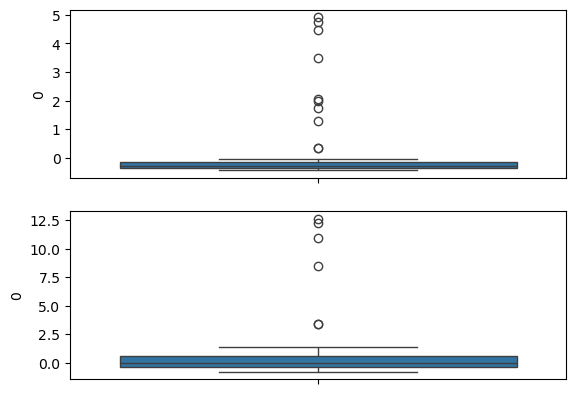

In [77]:
# Assume you want to check outliers for each feature
fig, (ax1, ax2) = plt.subplots(2)
sns.boxplot(ax=ax1, data=scaler_transform[0])
sns.boxplot(ax=ax2, data=robust_scaler_transform[0])


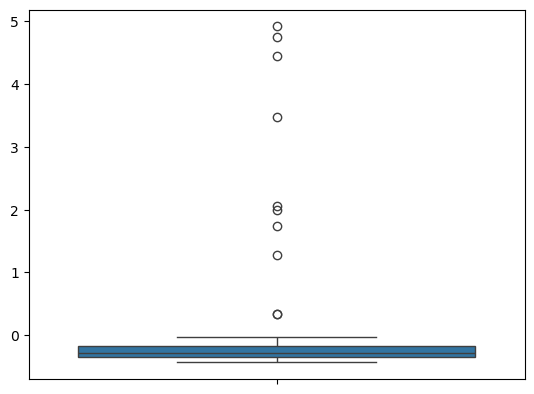

In [60]:
# Assume you want to check outliers for each feature
plt.figure()
sns.boxplot(data=X_short[:,-1])
plt.show()

In [140]:
y = y2.values

ohe = OneHotEncoder()
ohe.fit(X3.iloc[:,0:3])
ohe_transform = pd.DataFrame(ohe.transform(X3.iloc[:,0:3]).toarray())
# ohe.categories_

# scaler = StandardScaler()
# scaler_transform = pd.DataFrame(scaler.fit_transform(X3.loc[:,'Impact'].values.reshape(-1, 1)))

# robust_scaler = RobustScaler()
# robust_scaler_transform = pd.DataFrame(robust_scaler.fit_transform(X3.loc[:,'Impact'].values.reshape(-1, 1)))
# rz_scores = np.abs((robust_scaler_transform - np.mean(robust_scaler_transform, axis=0)) / np.std(robust_scaler_transform, axis=0))
# rthreshold = 1
# routliers = np.where(rz_scores > rthreshold)
# robust_scaler_transform = pd.DataFrame(np.delete(robust_scaler_transform, routliers[0], axis=0))
# ohe_transform = pd.DataFrame(np.delete(ohe_transform, routliers[0], axis=0))
# y = pd.DataFrame(np.delete(y2, routliers[0], axis=0))

# X = pd.concat([ohe_transform,scaler_transform], axis='columns')
# X = pd.concat([ohe_transform,robust_scaler_transform], axis='columns')
X = pd.concat([ohe_transform, X3.loc[:,'Impact']], axis='columns')
X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

rdf = RandomForestRegressor(n_estimators=1, random_state=42)
rdf.fit(X_train, y_train)

y_pred = rdf.predict(X_test)

# import pickle
# # Save the model to file
# pickle.dump(model, open("model_file.pkl", "wb"))

# # Restore the model from file
# restored_model = pickle.load(open("model_file.pkl", "rb"))

score, score_print = custom_score(X_train, X_test, y_train, y_test, y_pred, p=0.2)
score_print

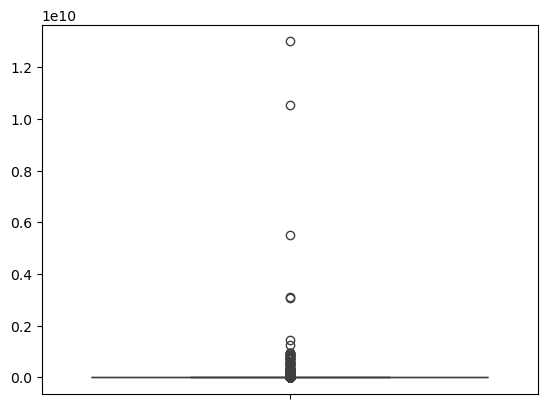

In [180]:
# Assume you want to check outliers for each feature
plt.figure()
sns.boxplot(data=X[:,-1])
plt.show()

Text(0, 0.5, 'predicted value')

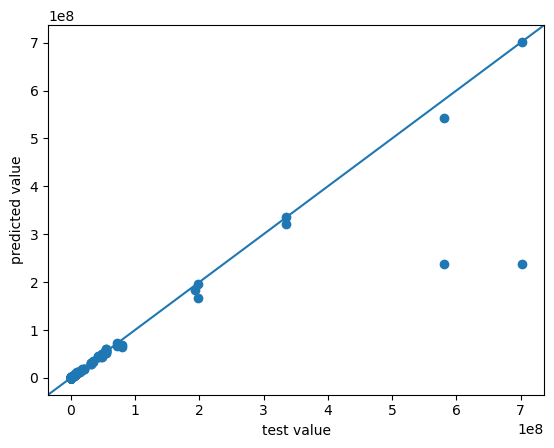

In [449]:
# true vs predicted value plot
fig, ax = plt.subplots()
ax.scatter(y_test[:,0], y_pred[:,0])
ax.axline((0,0), slope=1)
ax.set_xlabel('test value')
ax.set_ylabel('predicted value')

In [17]:
len(y_test[:,5])

19115

In [166]:
outlier = [i for i in range(len(y_test[:,0])) if y_test[i,0] > 3e8] # index for outlier
ohe.inverse_transform(X_test[outlier,0:320])

# why is that one point so far off?

array([['RER', 1, 'EDIP 2003']], dtype=object)

## Model full

In [77]:
# short data
# X = X_short
# y = y2.iloc[0:100,:].values

# full data
y = y2.values
ohe = OneHotEncoder()
ohe.fit(X3.iloc[:,0:3])
ohe_transform = pd.DataFrame(ohe.transform(X3.iloc[:,0:3]).toarray())
X = pd.concat([ohe_transform, X3.loc[:,'Impact']], axis='columns')
X = X.values

# Create a combined label for stratification
# This combines the multioutput targets into a single label for stratification
combined_labels = np.array([hash(tuple(row)) for row in y])

# Initialize model
rdf = RandomForestRegressor(n_estimators=10, random_state=42)
model = rdf

# Stratified k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fitted_model = []
scores = []
scores_print = []

for train_idx, test_idx in skf.split(X, combined_labels):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Clone the model to ensure a fresh start for each fold
    cloned_model = clone(model)
    cloned_model.fit(X_train, y_train)
    fitted_model.append(cloned_model)
    y_pred = cloned_model.predict(X_test)
    
    r1, r2 = custom_score(X_train, X_test, y_train, y_test, y_pred, p=0.2)
    scores.append(r1)
    scores_print.append(r2)



In [78]:
final_result_print = scores_full_model(scores)
display(final_result_print)

['MSE:   Average (STD)  |  9.22E+13 (1.42E+14)                Dummy model  |  1.84E+15 (2.20E+14)',
 'MdAE:  Average (STD)  |  1.31E-4 (2.50E-6)                  Dummy model  |  4.31E+5 (7.40E+3)',
 'ACPER: Average (STD)  |  92.85 (0.15)                       Dummy model  |  1.65E-1 (1.06E-2)',
 'Average R2: 0.9557930167819679 (0.0615834494850814)',
 'Average Explained Variance: 0.9557955605661114 (0.061579460014687705)']

In [79]:
scores_print

[['MSE:   Average (STD)  |  2.15E+12 (5.93E+12)                Dummy model  |  1.61E+15 (4.43E+15)',
  'MdAE:  Average (STD)  |  1.32E-4 (2.93E-4)                  Dummy model  |  4.42E+5 (8.07E+5)',
  'ACPER: Average (STD)  |  92.92 (1.55)                       Dummy model  |  1.56E-1 (7.71E-3)',
  'Average R-squared: 0.9988179157140693',
  'Average Explained Variance: 0.9988179159889928'],
 ['MSE:   Average (STD)  |  2.70E+13 (7.37E+13)                Dummy model  |  1.53E+15 (4.21E+15)',
  'MdAE:  Average (STD)  |  1.28E-4 (2.83E-4)                  Dummy model  |  4.37E+5 (7.98E+5)',
  'ACPER: Average (STD)  |  93.02 (2.15)                       Dummy model  |  1.50E-1 (7.38E-3)',
  'Average R-squared: 0.9786899548646883',
  'Average Explained Variance: 0.9786905067578652'],
 ['MSE:   Average (STD)  |  5.64E+13 (1.55E+14)                Dummy model  |  2.00E+15 (5.51E+15)',
  'MdAE:  Average (STD)  |  1.30E-4 (2.89E-4)                  Dummy model  |  4.26E+5 (7.78E+5)',
  'ACPER: 

In [80]:
feature_importance = pd.DataFrame(cloned_model.feature_importances_)
feature_importance.index = pd.concat([pd.DataFrame(ohe.categories_[0]), pd.DataFrame(ohe.categories_[1]), pd.DataFrame(ohe.categories_[2]), pd.DataFrame(['Impact'])], axis=0)
feature_importance[cloned_model.feature_importances_ > 0.01]

,0
"(EDIP 2003,)",0.219686
"(Impact,)",0.756798


In [443]:
feature_importance = pd.DataFrame(cloned_model.feature_importances_).T
feature_importance.columns = pd.concat([pd.DataFrame(ohe.categories_[0]), pd.DataFrame(ohe.categories_[1]), pd.DataFrame(ohe.categories_[2]), pd.DataFrame(['Impact'])], axis=0).T.values[0]
feature_importance['RoW'] # for reference flow np.nan, -1, 1

0    0.003483
Name: RoW, dtype: float64

In [450]:
# code to automate prediction (perhaps type a string and use ohe to convert it to the correct ohe'd vector?)
input_geography = 'CN'
input_reference_flow = 1
input_LCIA_method = 'TRACI v2.1'
input_impact = 0.24
predicted_LCIA_method = ['CML v4.8 2016', 
                         'EDIP 2003', 
                         'EF v3.0', 
                         'EF v3.1',
                         'IMPACT 2002+ (Midpoint)', 
                         'ReCiPe 2016 v1.03, midpoint (E)',
                         'ReCiPe 2016 v1.03, midpoint (H)', 
                         'ReCiPe 2016 v1.03, midpoint (I)',
                         'TRACI v2.1']

input_ohe = pd.DataFrame(ohe.transform([[input_geography, input_reference_flow, input_LCIA_method]]).toarray())
input_final = pd.concat([input_ohe, pd.DataFrame([input_impact])], axis=1)

prediction = cloned_model.predict(input_final)

desired_list = [y2.columns.get_loc(i) for i in predicted_LCIA_method]
desired_prediction = pd.DataFrame([prediction[0][i] for i in desired_list]).T
desired_prediction.columns = predicted_LCIA_method
desired_prediction

c:\Users\ajs8911\Miniconda3\envs\system_analysis\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


,CML v4.8 2016,EDIP 2003,EF v3.0,EF v3.1,IMPACT 2002+ (Midpoint),"ReCiPe 2016 v1.03, midpoint (E)","ReCiPe 2016 v1.03, midpoint (H)","ReCiPe 2016 v1.03, midpoint (I)",TRACI v2.1
0,0.252251,4.102846,0.298173,0.298173,0.239412,0.209264,0.209264,0.209265,0.241047


# Ecotoxicity:freshwater ML model

In [81]:
dropcolumns = y_excel.columns[y_excel.columns.str.contains('endpoint')]
dropcolumns1 = y_excel.columns[y_excel.columns.str.contains('Endpoint')]
y1_ecotox = y_excel.drop(dropcolumns, axis='columns')
y1_ecotox = y1_ecotox.drop(dropcolumns1, axis='columns')
y1_ecotox = y1_ecotox.columns[y1_ecotox.apply(lambda x: x.str.contains("ecotoxicity").any() and x.str.contains("freshwater").any() and not x.str.contains("no LT").any())]
y1_ecotox

Index(['CML v4.8 2016.2', 'EF v3.0.5', 'EF v3.0.6', 'EF v3.0.7', 'EF v3.0.8',
       'EF v3.1.5', 'EF v3.1.6', 'EF v3.1.7',
       'ReCiPe 2016 v1.03, midpoint (E).2',
       'ReCiPe 2016 v1.03, midpoint (H).2',
       'ReCiPe 2016 v1.03, midpoint (I).2', 'TRACI v2.1.2'],
      dtype='object')

In [82]:
y_excel.loc[:, y1_ecotox]

,CML v4.8 2016.2,EF v3.0.5,EF v3.0.6,EF v3.0.7,EF v3.0.8,EF v3.1.5,EF v3.1.6,EF v3.1.7,"ReCiPe 2016 v1.03, midpoint (E).2","ReCiPe 2016 v1.03, midpoint (H).2","ReCiPe 2016 v1.03, midpoint (I).2",TRACI v2.1.2
0,ecotoxicity: freshwater,ecotoxicity: freshwater,"ecotoxicity: freshwater, inorganics","ecotoxicity: freshwater, metals","ecotoxicity: freshwater, organics",ecotoxicity: freshwater,"ecotoxicity: freshwater, inorganics","ecotoxicity: freshwater, organics",ecotoxicity: freshwater,ecotoxicity: freshwater,ecotoxicity: freshwater,ecotoxicity: freshwater
1,freshwater aquatic ecotoxicity (FAETP inf),comparative toxic unit for ecosystems (CTUe),comparative toxic unit for ecosystems (CTUe),comparative toxic unit for ecosystems (CTUe),comparative toxic unit for ecosystems (CTUe),comparative toxic unit for ecosystems (CTUe),comparative toxic unit for ecosystems (CTUe),comparative toxic unit for ecosystems (CTUe),freshwater ecotoxicity potential (FETP),freshwater ecotoxicity potential (FETP),freshwater ecotoxicity potential (FETP),ecotoxicity: freshwater
2,"kg 1,4-DCB-Eq",CTUe,CTUe,CTUe,CTUe,CTUe,CTUe,CTUe,"kg 1,4-DCB-Eq","kg 1,4-DCB-Eq","kg 1,4-DCB-Eq",CTUe
3,4.364655,138.161536,17.765892,119.350438,1.045206,23.457416,22.38845,1.068966,0.4706,0.467955,0.430665,146.363729
4,4.931398,150.65439,19.74952,129.808983,1.095888,25.766126,24.642632,1.123494,0.551968,0.54943,0.505371,171.164395
...,...,...,...,...,...,...,...,...,...,...,...,...
21236,2.780835,125.192507,16.213293,107.736534,1.24268,21.442937,20.157835,1.285102,0.219492,0.218282,0.202275,70.180125
21237,111.232431,570.660637,75.053002,489.456727,6.150908,106.994125,100.737331,6.256794,2.934455,2.928576,2.829977,1688.417731
21238,114.974304,998.523664,97.851736,891.76373,8.908198,141.24197,132.186882,9.055088,3.102008,3.095369,2.989728,1741.563379
21239,114.980216,936.222235,82.692869,844.949303,8.580062,124.257924,115.546065,8.71186,3.111786,3.105594,2.999908,1741.471426


In [83]:
y2 = y_excel.loc[3:, y1_ecotox]
df_columnnames = y_excel.loc[0, y1_ecotox]
y2.columns = y2.columns + ' ' + df_columnnames # make LCIA column names unique
df1 = pd.DataFrame(y_excel.loc[:, y1_ecotox].columns) # y df containing only the LCIA method names
y2 = y2.loc[y2.index.repeat(len(df1))].reset_index(drop=True) # repeat each instance as many times as there are targets to be congruent with X
y2

,CML v4.8 2016.2 ecotoxicity: freshwater,EF v3.0.5 ecotoxicity: freshwater,"EF v3.0.6 ecotoxicity: freshwater, inorganics","EF v3.0.7 ecotoxicity: freshwater, metals","EF v3.0.8 ecotoxicity: freshwater, organics",EF v3.1.5 ecotoxicity: freshwater,"EF v3.1.6 ecotoxicity: freshwater, inorganics","EF v3.1.7 ecotoxicity: freshwater, organics","ReCiPe 2016 v1.03, midpoint (E).2 ecotoxicity: freshwater","ReCiPe 2016 v1.03, midpoint (H).2 ecotoxicity: freshwater","ReCiPe 2016 v1.03, midpoint (I).2 ecotoxicity: freshwater",TRACI v2.1.2 ecotoxicity: freshwater
0,4.364655,138.161536,17.765892,119.350438,1.045206,23.457416,22.38845,1.068966,0.4706,0.467955,0.430665,146.363729
1,4.364655,138.161536,17.765892,119.350438,1.045206,23.457416,22.38845,1.068966,0.4706,0.467955,0.430665,146.363729
2,4.364655,138.161536,17.765892,119.350438,1.045206,23.457416,22.38845,1.068966,0.4706,0.467955,0.430665,146.363729
3,4.364655,138.161536,17.765892,119.350438,1.045206,23.457416,22.38845,1.068966,0.4706,0.467955,0.430665,146.363729
4,4.364655,138.161536,17.765892,119.350438,1.045206,23.457416,22.38845,1.068966,0.4706,0.467955,0.430665,146.363729
...,...,...,...,...,...,...,...,...,...,...,...,...
254851,0.098465,10.680944,1.73835,8.360101,0.582493,2.539908,1.956326,0.583581,0.007613,0.007534,0.006886,2.611404
254852,0.098465,10.680944,1.73835,8.360101,0.582493,2.539908,1.956326,0.583581,0.007613,0.007534,0.006886,2.611404
254853,0.098465,10.680944,1.73835,8.360101,0.582493,2.539908,1.956326,0.583581,0.007613,0.007534,0.006886,2.611404
254854,0.098465,10.680944,1.73835,8.360101,0.582493,2.539908,1.956326,0.583581,0.007613,0.007534,0.006886,2.611404


In [85]:
# Get X and y into the correct shapes for creating training data
df1 = pd.DataFrame(y1_ecotox) # y df containing only the LCIA method names
df3 = pd.DataFrame(y_excel.loc[3:, y1_ecotox].values.reshape(1, -1)[0]) # reshape the y df to be a single column of values

# Create dataframe2
df2 = X2

# Expand dataframe2 to repeat each row for each row in dataframe1
df2_expanded = df2.loc[df2.index.repeat(len(df1))].reset_index(drop=True)

# Repeat dataframe1 to match the expanded dataframe2
df1_repeated = pd.concat([df1]*len(df2)).reset_index(drop=True)

# Combine the expanded dataframe2 with the repeated dataframe1
X3 = pd.concat([df2_expanded, df1_repeated, df3], axis=1)

# Rename the columns for clarity
X3.columns = list(df2.columns) + ['LCIA_method', 'Impact']

# # Apply the transformation: if 'acidification' in Category_1 or Category_2, set Category_1 to 'acidification'
# df_result.loc[(df_result['Category_1'].str.contains('acidification')) | (df_result['Category_2'].str.contains('acidification')), 'Category_1'] = 'acidification'

X3

,Geography,Reference Product Amount,LCIA_method,Impact
0,RoW,1,CML v4.8 2016.2,4.364655
1,RoW,1,EF v3.0.5,138.161536
2,RoW,1,EF v3.0.6,17.765892
3,RoW,1,EF v3.0.7,119.350438
4,RoW,1,EF v3.0.8,1.045206
...,...,...,...,...
254851,GLO,1,EF v3.1.7,0.583581
254852,GLO,1,"ReCiPe 2016 v1.03, midpoint (E).2",0.007613
254853,GLO,1,"ReCiPe 2016 v1.03, midpoint (H).2",0.007534
254854,GLO,1,"ReCiPe 2016 v1.03, midpoint (I).2",0.006886


In [86]:
# short data
# X = X_short
# y = y2.iloc[0:100,:].values

# full data
y = y2.values
ohe = OneHotEncoder()
ohe.fit(X3.iloc[:,0:3])
ohe_transform = pd.DataFrame(ohe.transform(X3.iloc[:,0:3]).toarray())
X = pd.concat([ohe_transform, X3.loc[:,'Impact']], axis='columns')
X = X.values

# Create a combined label for stratification
# This combines the multioutput targets into a single label for stratification
combined_labels = np.array([hash(tuple(row)) for row in y])

# Initialize model
rdf = RandomForestRegressor(n_estimators=10, random_state=42)
model = rdf

# Stratified k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fitted_model = []
scores = []
scores_print = []

for train_idx, test_idx in skf.split(X, combined_labels):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Clone the model to ensure a fresh start for each fold
    cloned_model = clone(model)
    cloned_model.fit(X_train, y_train)
    fitted_model.append(cloned_model)
    y_pred = cloned_model.predict(X_test)
    
    r1, r2 = custom_score(X_train, X_test, y_train, y_test, y_pred, p=0.2)
    scores.append(r1)
    scores_print.append(r2)

final_result_print = scores_full_model(scores)
display(final_result_print)

['MSE:   Average (STD)  |  5.15E+19 (1.00E+19)                Dummy model  |  2.87E+20 (2.02E+19)',
 'MdAE:  Average (STD)  |  1.34E+0 (1.56E-2)                  Dummy model  |  2.48E+8 (1.89E+6)',
 'ACPER: Average (STD)  |  45.70 (0.09)                       Dummy model  |  1.86E-1 (3.58E-3)',
 'Average R2: 0.8448112911075606 (0.015166256789948063)',
 'Average Explained Variance: 0.8448159714341387 (0.015166117113051363)']

In [475]:
scores_print

[['MSE:   Average (STD)  |  6.46E+19 (1.33E+20)                Dummy model  |  2.75E+20 (4.70E+20)',
  'MdAE:  Average (STD)  |  1.20E+0 (1.57E+0)                  Dummy model  |  2.49E+8 (3.58E+8)',
  'ACPER: Average (STD)  |  45.62 (4.41)                       Dummy model  |  1.85E-1 (3.56E-2)',
  'Average R-squared: 0.8303353951602785',
  'Average Explained Variance: 0.8303460360857833'],
 ['MSE:   Average (STD)  |  4.60E+19 (8.39E+19)                Dummy model  |  2.74E+20 (4.68E+20)',
  'MdAE:  Average (STD)  |  1.20E+0 (1.55E+0)                  Dummy model  |  2.50E+8 (3.59E+8)',
  'ACPER: Average (STD)  |  45.54 (4.44)                       Dummy model  |  1.92E-1 (4.24E-2)',
  'Average R-squared: 0.8580934910079069',
  'Average Explained Variance: 0.8580957309481597'],
 ['MSE:   Average (STD)  |  3.45E+19 (6.16E+19)                Dummy model  |  2.66E+20 (4.53E+20)',
  'MdAE:  Average (STD)  |  1.18E+0 (1.54E+0)                  Dummy model  |  2.50E+8 (3.60E+8)',
  'ACPER: 

Text(0, 0.5, 'predicted value')

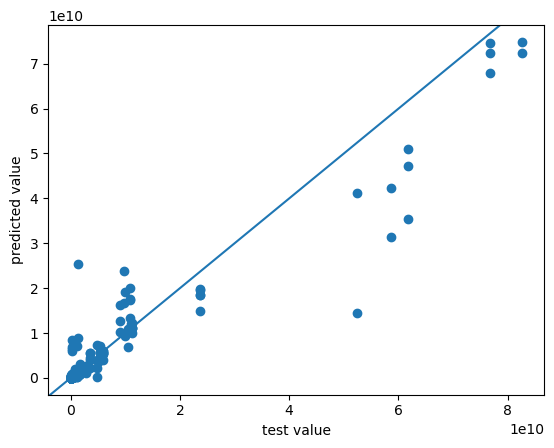

In [87]:
# true vs predicted value plot
fig, ax = plt.subplots()
ax.scatter(y_test[:,0], y_pred[:,0])
ax.axline((0,0), slope=1)
ax.set_xlabel('test value')
ax.set_ylabel('predicted value')

In [88]:
feature_importance = pd.DataFrame(cloned_model.feature_importances_)
feature_importance.index = pd.concat([pd.DataFrame(ohe.categories_[0]), pd.DataFrame(ohe.categories_[1]), pd.DataFrame(ohe.categories_[2]), pd.DataFrame(['Impact'])], axis=0)
feature_importance[cloned_model.feature_importances_ > 0.01]

,0
"(CA-QC,)",0.178050
"(RER,)",0.010509
"(RoW,)",0.048270
"(CML v4.8 2016.2,)",0.014385
"(EF v3.0.6,)",0.023120
"(EF v3.0.8,)",0.018982
"(EF v3.1.5,)",0.016502
"(EF v3.1.7,)",0.033863
"(ReCiPe 2016 v1.03, midpoint (E).2,)",0.025859
"(ReCiPe 2016 v1.03, midpoint (H).2,)",0.035943


# Global Warming: ML model

In [89]:
dropcolumns = y_excel.columns[y_excel.columns.str.contains('endpoint')]
dropcolumns1 = y_excel.columns[y_excel.columns.str.contains('Endpoint')]
dropcolumns2 = y_excel.columns[y_excel.columns.str.contains('IPCC')]
dropcolumns3 = y_excel.columns[y_excel.columns.str.contains('Ecological Scarcity')]
# y1_gw = y_raw.drop(dropcolumns, axis='columns')
# y1_gw = y1_gw.drop(dropcolumns1, axis='columns')
# y1_gw = y1_gw.drop(dropcolumns2, axis='columns')
y1_gw = y_excel.drop(pd.concat([pd.DataFrame(dropcolumns), pd.DataFrame(dropcolumns1), pd.DataFrame(dropcolumns2), pd.DataFrame(dropcolumns3)], axis=0)[0], axis='columns')
y1_gw = y1_gw.columns[y1_gw.apply(lambda x: x.str.contains("global warming").any() and not x.str.contains("no LT").any())]
y1_gw

Index(['CML v4.8 2016.1', 'EDIP 2003.9', 'EDIP 2003.10', 'EDIP 2003.11',
       'EF v3.0.1', 'EF v3.0.2', 'EF v3.0.3', 'EF v3.0.4', 'EF v3.1.1',
       'EF v3.1.2', 'EF v3.1.3', 'EF v3.1.4',
       'ReCiPe 2016 v1.03, midpoint (E).1',
       'ReCiPe 2016 v1.03, midpoint (H).1',
       'ReCiPe 2016 v1.03, midpoint (I).1', 'TRACI v2.1.1'],
      dtype='object')

In [90]:
y_excel.loc[:, y1_gw]

,CML v4.8 2016.1,EDIP 2003.9,EDIP 2003.10,EDIP 2003.11,EF v3.0.1,EF v3.0.2,EF v3.0.3,EF v3.0.4,EF v3.1.1,EF v3.1.2,EF v3.1.3,EF v3.1.4,"ReCiPe 2016 v1.03, midpoint (E).1","ReCiPe 2016 v1.03, midpoint (H).1","ReCiPe 2016 v1.03, midpoint (I).1",TRACI v2.1.1
0,climate change,global warming,global warming,global warming,climate change,climate change: biogenic,climate change: fossil,climate change: land use and land use change,climate change,climate change: biogenic,climate change: fossil,climate change: land use and land use change,climate change,climate change,climate change,climate change
1,global warming potential (GWP100),GWP 100a,GWP 20a,GWP 500a,global warming potential (GWP100),global warming potential (GWP100),global warming potential (GWP100),global warming potential (GWP100),global warming potential (GWP100),global warming potential (GWP100),global warming potential (GWP100),global warming potential (GWP100),global warming potential (GWP1000),global warming potential (GWP100),global warming potential (GWP20),global warming potential (GWP100)
2,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq
3,5.985279,5.692135,10.183686,4.328673,6.512596,0.011063,6.493755,0.007777,6.366987,0.008785,6.350436,0.007765,4.081811,6.496882,11.792881,5.75652
4,5.942794,5.653742,10.129539,4.29833,6.465592,0.009276,6.449621,0.006695,6.324305,0.007366,6.310257,0.006682,4.051019,6.450339,11.725748,5.715381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21236,4.116431,4.080038,4.474047,3.899195,4.219114,0.007801,4.205802,0.005511,4.137264,0.006195,4.125577,0.005492,3.85598,4.204839,4.699458,4.089978
21237,18.677035,22.478278,24.606624,21.531518,22.347513,0.039957,22.290962,0.016593,18.785921,0.03173,18.737649,0.016541,17.311456,19.143079,21.813157,18.529182
21238,33.700046,37.224636,41.558103,35.338631,37.899277,0.064393,37.789474,0.04541,33.914683,0.051136,33.818216,0.045332,30.977879,34.63415,40.072909,33.390723
21239,31.189382,34.854811,38.213203,33.372417,35.165216,0.042939,35.097193,0.025084,31.360407,0.034098,31.30129,0.025019,29.049872,31.923514,36.136643,30.954252


In [91]:
y2 = y_excel.loc[3:, y1_gw]
df_columnnames = y_excel.loc[0, y1_gw]
y2.columns = y2.columns + ' ' + df_columnnames # make LCIA column names unique
df1 = pd.DataFrame(y_excel.loc[:, y1_gw].columns) # y df containing only the LCIA method names
y2 = y2.loc[y2.index.repeat(len(df1))].reset_index(drop=True) # repeat each instance as many times as there are targets to be congruent with X
y2

,CML v4.8 2016.1 climate change,EDIP 2003.9 global warming,EDIP 2003.10 global warming,EDIP 2003.11 global warming,EF v3.0.1 climate change,EF v3.0.2 climate change: biogenic,EF v3.0.3 climate change: fossil,EF v3.0.4 climate change: land use and land use change,EF v3.1.1 climate change,EF v3.1.2 climate change: biogenic,EF v3.1.3 climate change: fossil,EF v3.1.4 climate change: land use and land use change,"ReCiPe 2016 v1.03, midpoint (E).1 climate change","ReCiPe 2016 v1.03, midpoint (H).1 climate change","ReCiPe 2016 v1.03, midpoint (I).1 climate change",TRACI v2.1.1 climate change
0,5.985279,5.692135,10.183686,4.328673,6.512596,0.011063,6.493755,0.007777,6.366987,0.008785,6.350436,0.007765,4.081811,6.496882,11.792881,5.75652
1,5.985279,5.692135,10.183686,4.328673,6.512596,0.011063,6.493755,0.007777,6.366987,0.008785,6.350436,0.007765,4.081811,6.496882,11.792881,5.75652
2,5.985279,5.692135,10.183686,4.328673,6.512596,0.011063,6.493755,0.007777,6.366987,0.008785,6.350436,0.007765,4.081811,6.496882,11.792881,5.75652
3,5.985279,5.692135,10.183686,4.328673,6.512596,0.011063,6.493755,0.007777,6.366987,0.008785,6.350436,0.007765,4.081811,6.496882,11.792881,5.75652
4,5.985279,5.692135,10.183686,4.328673,6.512596,0.011063,6.493755,0.007777,6.366987,0.008785,6.350436,0.007765,4.081811,6.496882,11.792881,5.75652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339803,0.182185,0.176919,0.192015,0.156045,0.190703,0.000195,0.181756,0.008752,0.183773,0.000155,0.174867,0.008751,0.153601,0.188983,0.207183,0.184135
339804,0.182185,0.176919,0.192015,0.156045,0.190703,0.000195,0.181756,0.008752,0.183773,0.000155,0.174867,0.008751,0.153601,0.188983,0.207183,0.184135
339805,0.182185,0.176919,0.192015,0.156045,0.190703,0.000195,0.181756,0.008752,0.183773,0.000155,0.174867,0.008751,0.153601,0.188983,0.207183,0.184135
339806,0.182185,0.176919,0.192015,0.156045,0.190703,0.000195,0.181756,0.008752,0.183773,0.000155,0.174867,0.008751,0.153601,0.188983,0.207183,0.184135


In [92]:
# Get X and y into the correct shapes for creating training data
df1 = pd.DataFrame(y1_gw) # y df containing only the LCIA method names
df3 = pd.DataFrame(y_excel.loc[3:, y1_gw].values.reshape(1, -1)[0]) # reshape the y df to be a single column of values

# Create dataframe2
df2 = X2

# Expand dataframe2 to repeat each row for each row in dataframe1
df2_expanded = df2.loc[df2.index.repeat(len(df1))].reset_index(drop=True)

# Repeat dataframe1 to match the expanded dataframe2
df1_repeated = pd.concat([df1]*len(df2)).reset_index(drop=True)

# Combine the expanded dataframe2 with the repeated dataframe1
X3 = pd.concat([df2_expanded, df1_repeated, df3], axis=1)

# Rename the columns for clarity
X3.columns = list(df2.columns) + ['LCIA_method', 'Impact']

# # Apply the transformation: if 'acidification' in Category_1 or Category_2, set Category_1 to 'acidification'
# df_result.loc[(df_result['Category_1'].str.contains('acidification')) | (df_result['Category_2'].str.contains('acidification')), 'Category_1'] = 'acidification'

X3

,Geography,Reference Product Amount,LCIA_method,Impact
0,RoW,1,CML v4.8 2016.1,5.985279
1,RoW,1,EDIP 2003.9,5.692135
2,RoW,1,EDIP 2003.10,10.183686
3,RoW,1,EDIP 2003.11,4.328673
4,RoW,1,EF v3.0.1,6.512596
...,...,...,...,...
339803,GLO,1,EF v3.1.4,0.008751
339804,GLO,1,"ReCiPe 2016 v1.03, midpoint (E).1",0.153601
339805,GLO,1,"ReCiPe 2016 v1.03, midpoint (H).1",0.188983
339806,GLO,1,"ReCiPe 2016 v1.03, midpoint (I).1",0.207183


In [93]:
# short data
# X = X_short
# y = y2.iloc[0:100,:].values

# full data
y = y2.values
ohe = OneHotEncoder()
ohe.fit(X3.iloc[:,0:3])
ohe_transform = pd.DataFrame(ohe.transform(X3.iloc[:,0:3]).toarray())
X = pd.concat([ohe_transform, X3.loc[:,'Impact']], axis='columns')
X = X.values

# Create a combined label for stratification
# This combines the multioutput targets into a single label for stratification
combined_labels = np.array([hash(tuple(row)) for row in y])

# Initialize model
rdf = RandomForestRegressor(n_estimators=10, random_state=42)
model = rdf

# Stratified k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

train_test_data = []
fitted_model = []
scores = []
scores_print = []

for train_idx, test_idx in skf.split(X, combined_labels):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_test_data.append([X_train, X_test, y_train, y_test])
    
    # Clone the model to ensure a fresh start for each fold
    cloned_model = clone(model)
    cloned_model.fit(X_train, y_train)
    fitted_model.append(cloned_model)
    y_pred = cloned_model.predict(X_test)
    
    r1, r2 = custom_score(X_train, X_test, y_train, y_test, y_pred, p=0.2)
    scores.append(r1)
    scores_print.append(r2)

# Save the model to file
lcia_cat = 'gw'
# joblib.dump(fitted_model, f"{lcia_cat}_model.pkl", compress=9)
# joblib.dump(train_test_data, f"{lcia_cat}_train_test_data.pkl", compress=9)

final_result_print = scores_full_model(scores)
display(final_result_print)

['MSE:   Average (STD)  |  3.18E+17 (1.83E+17)                Dummy model  |  2.27E+18 (1.38E+17)',
 'MdAE:  Average (STD)  |  3.19E-2 (5.56E-4)                  Dummy model  |  2.71E+7 (2.23E+5)',
 'ACPER: Average (STD)  |  64.79 (0.12)                       Dummy model  |  1.44E-1 (3.91E-3)',
 'Average R2: 0.8650306185284069 (0.07191855796156156)',
 'Average Explained Variance: 0.8650342526358799 (0.07191717067159312)']

Text(0, 0.5, 'predicted value')

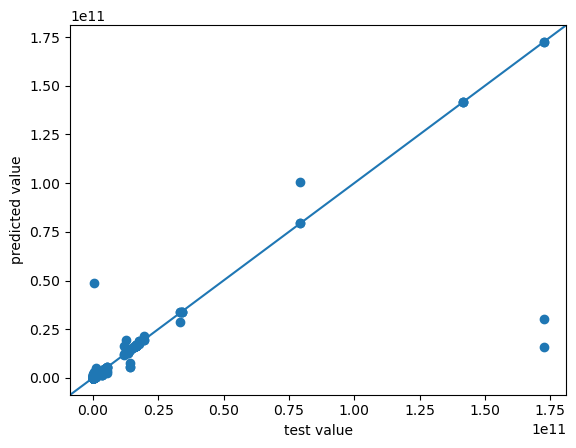

In [94]:
# true vs predicted value plot
index = 0
fig, ax = plt.subplots()
ax.scatter(y_test[:,index], y_pred[:,index])
ax.axline((0,0), slope=1)
ax.set_xlabel('test value')
ax.set_ylabel('predicted value')

In [95]:
feature_importance = pd.DataFrame(cloned_model.feature_importances_)
feature_importance.index = pd.concat([pd.DataFrame(ohe.categories_[0]), pd.DataFrame(ohe.categories_[1]), pd.DataFrame(ohe.categories_[2]), pd.DataFrame(['Impact'])], axis=0)
feature_importance[cloned_model.feature_importances_ > 0.01]

,0
"(RER,)",0.034394
"(EF v3.0.2,)",0.068123
"(EF v3.0.4,)",0.014660
"(EF v3.1.2,)",0.041085
"(EF v3.1.4,)",0.013805
"(Impact,)",0.807182
